# about langgraph
- Each node:
1. receives a state
2. transforms it
3. passes it forward

- Use case:
Node A: call an LLM to draft a greeting (costly, nondeterministic)
Node B: fetch/validate age from a database or API (I/O, can fail)
Node C: infer skills from a resume via embedding search (RAG, more cost)

follow course on youtube
https://www.youtube.com/watch?v=jGg_1h0qzaM

In [1]:
from typing import Dict, TypedDict, List
from langgraph.graph import StateGraph
from IPython.display import Image, display

In [4]:
class AgentState(TypedDict):
    message: str 


def  greeting_node(state: AgentState) -> AgentState:
    """ Simple node that adds a greeting message to this state """
    
    state['message'] = "Hey," + state['message'] + ", how are you doing?"
    
    return state
    

In [18]:
graph = StateGraph(AgentState)

graph.add_node("greeter", greeting_node)
graph.set_entry_point("greeter")
graph.set_finish_point("greeter")

app = graph.compile()   #necessary! or can't show the graph or invoke the graph(actually invoked is the compiled app)

In [7]:
result = app.invoke({"message":"LL"})

In [8]:
result['message']

'Hey,LL, how are you doing?'

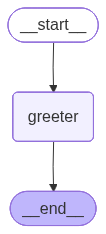

In [ ]:
png_bytes = app.get_graph().draw_mermaid_png()
display(Image(data=png_bytes))

# graph II: multiple inputs graph
1. more complex AgentState
2. work with lists, instead of just strings
3. handle multiple inputs

In [20]:
class AgentState(TypedDict): # can be named anything other than AgentState
    values: List[int]
    name: str
    result: str 

In [31]:
def process_values(state: AgentState) -> AgentState:
    """ This function handles multiple different inputs """
    print(state)
    state["result"] = f"Hi there {state['name']}! Your sum = {sum(state['values'])}"

    print(state)
    return state

In [33]:
graph = StateGraph(AgentState)

graph.add_node("processor", process_values)
graph.set_entry_point("processor")
graph.set_finish_point("processor")

app = graph.compile()

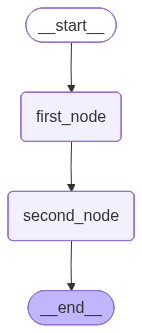

In [8]:
png_bytes = app.get_graph().draw_mermaid_png()
display(Image(data=png_bytes))

In [ ]:
answers = app.invoke({"values":[1,2,3], "name":"LL"})

In [29]:
print(answers)

{'values': [1, 2, 3], 'name': 'LL', 'result': 'Hi there LL! Your sum = 6'}


In [26]:
print(answers["result"])

Hi there LL! Your sum = 6


# graph III: sequential graph

In [15]:
class AgentState(TypedDict):
    name: str
    age: str    #it's just a static type hint, not a runtime constraint, which means there won't be errors if i put in other types
    final: str

In [10]:
def first_node(state:AgentState) -> AgentState:
    """ This is the first node of our sequence """
    
    state["final"] = f"Hi {state['name']}! "
    return state 

def second_node(state:AgentState) -> AgentState:
    """ This is the second node of our sequence """

    state["final"] = state["final"] + f"You are {state['age']} years old!"
    return state

In [11]:
graph = StateGraph(AgentState)

graph.add_node("first_node", first_node)
graph.add_node("second_node", second_node)

graph.set_entry_point("first_node")
graph.add_edge("first_node", "second_node")
graph.set_finish_point("second_node")

app = graph.compile()

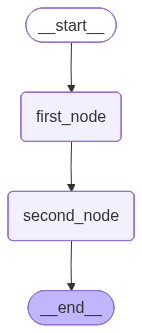

In [12]:
png_bytes = app.get_graph().draw_mermaid_png()
display(Image(data=png_bytes))

In [16]:
result = app.invoke({"name":"LL", "age":30})
print(result)

{'name': 'LL', 'age': 30, 'final': 'Hi LL! You are 30 years old!'}


## exercise

In [19]:
class AgentState(TypedDict):
    name: str
    age: str
    skills: List[str] 

In [32]:
def first_node(state:AgentState) -> AgentState:
    """ This is the first node: greet the person """
    
    state['first'] = f"{state['name']}, welcome to the system! "
    return state

def second_node(state:AgentState) -> AgentState:
    """ This is the second node: describe age """
    
    state['second'] = state['first'] + f"You are {state['age']} years old. "
    return state

def third_node(state:AgentState) -> AgentState:
    """ This is the third node: list skills """
    
    skills_str = ",".join(state['skills'])
    state['final'] = state['second'] + f"You have skills in: {skills_str}"
    return state

# something wrong with the second and maybe third...but don't know what's wrong

In [29]:
graph = StateGraph(AgentState)

graph.add_node("first_node", first_node)
graph.add_node("second_node", second_node)
graph.add_node("third_node", third_node)

graph.set_entry_point("first_node")
graph.add_edge("first_node", "second_node")
graph.add_edge("second_node", "third_node")
graph.set_finish_point("third_node")

app = graph.compile()

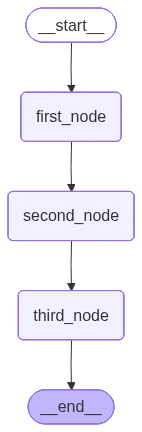

In [30]:
png_bytes = app.get_graph().draw_mermaid_png()
display(Image(data=png_bytes))

In [ ]:
result = app.invoke({"name":"LL", "age":30, "skills":["Python","SQL"]})
print(result)

# graph IV: conditional graph
1. conditional logic
2. use "add_conditional_edges()" this function

In [2]:
from typing import TypedDict, NotRequired, Literal
from langgraph.graph import StateGraph, START, END

In [31]:
class AgentState(TypedDict):
    number1: int 
    number2: int
    operation: Literal["+","-"] # or just "operation: str"
    finalNumber: int

In [32]:
def adder(state: AgentState) -> dict:
    state["finalNumber"] = state["number1"] + state["number2"]
    return state
def subtractor(state: AgentState) -> dict:
    state["finalNumber"] = state["number1"] - state["number2"]
    return state

def decide_next_node(state: AgentState) -> AgentState:
    if state["operation"] == "+":
        return "addition_operation"
    elif state["operation"] == "-":
        return "subtraction_operation"

In [33]:
graph = StateGraph(AgentState)

graph.add_node("router", lambda state: state)      # no state update needed
graph.add_node("add_node", adder)
graph.add_node("subtract_node", subtractor)

graph.add_edge(START, "router")

graph.add_conditional_edges(
    "router", 
    decide_next_node,
    {
        # Edge: Node
        "addition_operation": "add_node",
        "subtractor_operation": "subtract_node"
    }
    
    )

graph.add_edge("add_node", END)
graph.add_edge("subtract_node", END)

app = graph.compile()

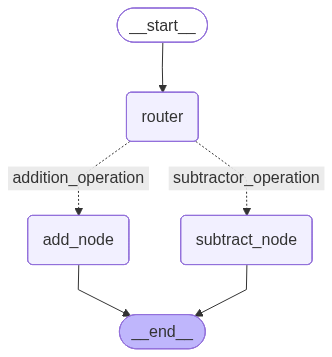

In [34]:
png_bytes = app.get_graph().draw_mermaid_png()
display(Image(data=png_bytes))

In [ ]:
initial_state_1 = AgentState(number1 = 10, operation='-', number2 = 2, finalNumber=0)
# must contain "finalNumber" in initial_state_1!!! or the result won't show it
result = app.invoke(initial_state_1)
print(result)

{'number1': 10, 'number2': 2, 'operation': '-'}


## exercise
two conditional edges

In [35]:
class AgentState(TypedDict):
    number1: int
    number2: int
    number3: int
    number4: int
    finalnumber1: int
    finalnumber2: int
    operation1: Literal["+","-"]
    operation2: Literal["+","-"]

In [36]:
def adder1(state:AgentState) -> AgentState:
    state["finalnumber1"] = state["number1"] + state["number2"]
    return state

def subtractor1(state:AgentState) -> AgentState:
    state["finalnumber1"] = state["number1"] - state["number2"]
    return state

def router1(state:AgentState) -> AgentState:
    if state["operation1"] == "+":
        return "addition_operation"
    
    elif state["operation1"] == "-":
        return "subtraction_operation"
    
def adder2(state:AgentState) -> AgentState:
    state["finalnumber2"] = state["number3"] + state["number4"]
    return state

def subtractor2(state:AgentState) -> AgentState:
    state["finalnumber2"] = state["number3"] - state["number4"]
    return state

def rounter2(state:AgentState) -> AgentState:
    if state["operation2"] == "+":
        return "addition_operation_2"
    
    elif state["operation2"] == "-":
        return "subtraction_operation_2"


In [37]:
graph = StateGraph(AgentState)
# nodex6, edgex7
graph.add_node("router1", lambda state: state)
graph.add_node("add_node1", adder)
graph.add_node("sub_node1", subtractor1)
graph.add_node("router2", lambda state: state)
graph.add_node("add_node2", adder2)
graph.add_node("sub_node2", subtractor2)

graph.add_edge(START, "router1")
graph.add_conditional_edges(
    "router1",
    router1,
    {
        "addition_operation": "add_node1",
        "subtraction_operation": "sub_node1"
    }
)
graph.add_edge("add_node1", "router2")
graph.add_edge("sub_node1", "router2")
graph.add_conditional_edges(
    "router2",
    rounter2,
    {
        "addition_operation_2": "add_node2",
        "subtraction_operation_2": "sub_node2"
    }
)
graph.add_edge("add_node2", END)
graph.add_edge("sub_node2", END)

app = graph.compile()

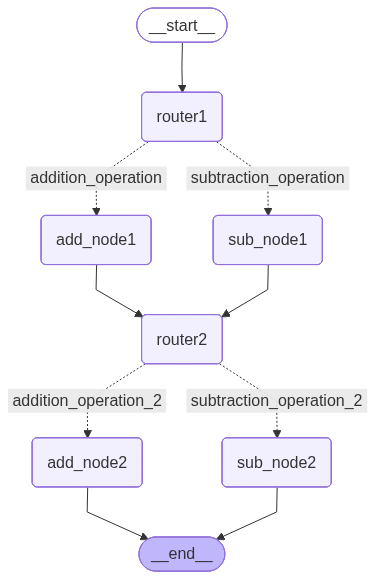

In [38]:
png_bytes = app.get_graph().draw_mermaid_png()
display(Image(data=png_bytes))

In [ ]:
initial_state = AgentState(number1=10, operation1="-", number2 = 5, number3 = 7, number4=2, operation2="+", finalnumber1=0, finalnumber2=0)
result = app.invoke(initial_state)
print(result)

# finalnumber is the element which went through the agents and got to its final state. however should first be mentioned in initial_state

{'number1': 10, 'number2': 5, 'number3': 7, 'number4': 2, 'finalnumber1': 5, 'finalnumber2': 9, 'operation1': '-', 'operation2': '+'}


# graph V: looping graph
20260108


In [40]:
import random

In [41]:
class AgentState(TypedDict):
    name: str
    number: List[int]
    counter: int

In [ ]:
def greeting_node(state: AgentState) -> AgentState:
    """Greeting node which says hi to the person"""
    state["name"] = f'Hi there, {state["name"]}'
    state["counter"] = 0
    
    return state

def random_node(state:AgentState) -> AgentState:
    """Generate a random number from 0 to 10"""
    state["number"].append(random.randint(0,10))
    state["counter"] += 1
    
    return state

def should_continue(state:AgentState) -> AgentState:
    """Function to decide what to do next"""
    
    if state["counter"] < 5:
        print("ENTERING LOOP", state["counter"])
        return "loop"   #Continue looping
    else:
        return "exit"   #Exit the loop

In [43]:
# gretting -> random -> random -> random -> random -> random -> END

In [ ]:
graph = StateGraph(AgentState)

graph.add_node("greeting", greeting_node)
graph.add_node("random", random_node)

# graph.add_edge(START, "greeting")   #can be omitted
graph.add_edge("greeting", "random")


graph.add_conditional_edges(
    "random",   #Source node
    should_continue,    #Action
    {
        "loop": "random",   #Self-loop back to the same node
        "exit": END #so no need to set exit point at the end
    }
)


app = graph.compile()

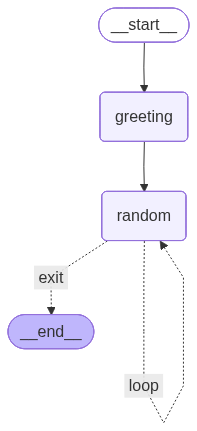

In [48]:
png_bytes = app.get_graph().draw_mermaid_png()
display(Image(data=png_bytes))

In [46]:
app.invoke({"name":"LL", "number":[], "counter":-1})

ENTERING LOOP 1
ENTERING LOOP 2
ENTERING LOOP 3
ENTERING LOOP 4


{'name': 'Hi there, LL', 'number': [9, 6, 4, 8, 7], 'counter': 5}

## exercise
implement an automatic higher or lower game

In [3]:
class AgentState(TypedDict):
    name: str
    guesses: List[int]  #numbers i guess
    attempts: int   #count guess times
    lower_bound: int
    upper_bound: int
    target_number: int

In [2]:
from langgraph.graph import StateGraph, START, END
import random

In [14]:
def setup_node(state:AgentState) -> AgentState:
    state["name"] = f"Hi, {state['name']}, welcome to the number guessing game!"
    state["guesses"] = []
    state["attempts"] = 0
    state["lower_bound"] = 1
    state["upper_bound"] = 20
    
    
    print('setup complete!')
    return state

def guess_node(state:AgentState) -> AgentState:
    guess = random.randint(state["lower_bound"], state["upper_bound"])
    state["guesses"].append(guess)
    state["attempts"] += 1
    
    print('guess complete!')
    return state

def decision_node(state:AgentState) -> AgentState:
    last_guess = state["guesses"][-1]
    
    if state["attempts"] > 7:
        print("Sorry, you've reached your max trys.")
        return "exit"
    elif last_guess == state["target_number"]:
        print("Congrat! Correct guess")
        return "exit"
    elif last_guess < state["target_number"]:
        state["lower_bound"] = last_guess + 1
        print(f"This is your {state['attempts']} attempt.")
        print(f"Your guess: {last_guess}, is too low. Please try larger between {state['lower_bound']} and {state['upper_bound']}.n/ You have {7 - state['attempts']} attempts left.")
        return "loop"
    elif last_guess > state["target_number"]:
        state["upper_bound"] = last_guess - 1
        print(f"This is your {state['attempts']} attempt.")
        print(f"Your guess: {last_guess}, is too high. Please try smaller between {state['lower_bound']} and {state['upper_bound']}.n/ You have {7 - state['attempts']} attempts left.")
        return "loop"

In [15]:
graph = StateGraph(AgentState)

graph.add_node("setup", setup_node)
graph.add_node("guess", guess_node)

graph.set_entry_point("setup")

graph.add_edge("setup", "guess")


graph.add_conditional_edges(
    "guess",   #Source node
    decision_node,    #Action
    {
        "loop": "guess",   #back to the same node #here "loop" should be the same from the one in def
        "exit": END #so no need to set exit point at the end
    }
)

app = graph.compile()

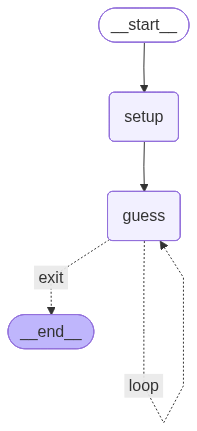

In [16]:
png_bytes = app.get_graph().draw_mermaid_png()
display(Image(data=png_bytes))

In [20]:
initial_state = AgentState(
    name = "LL",
    guesses = [],
    attempts = 0,
    lower_bound = 1,
    upper_bound = 20,
    target_number = 15
)

result = app.invoke(initial_state)
print(result)

setup complete!
guess complete!
This is your 1 attempt.
Your guess: 3, is too low. Please try larger between 4 and 20.n/ You have 6 attempts left.
guess complete!
Congrat! Correct guess
{'name': 'Hi, LL, welcome to the number guessing game!', 'guesses': [3, 15], 'attempts': 2, 'lower_bound': 1, 'upper_bound': 20, 'target_number': 15}
